In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df=pd.read_csv('data_v1/df_final.csv')

In [18]:
latest_stops_df = df.loc[df.groupby(["raceId", "driverId", "constructorId"])["stop"].idxmax()]

In [19]:
latest_stops_df.to_csv('data_v1/latest_stops_df.csv', index=False)

In [20]:
latest_stops_df.rename(columns={'stop':'numStops'}, inplace=True)


In [21]:
latest_stops_df.drop(['lap','milliseconds'],axis=1,inplace=True)

In [28]:
#position=1 as 1 else 0
latest_stops_df['positionOrder'] = latest_stops_df['positionOrder'].apply(lambda x: 1 if x==1 else 0)

In [30]:
latest_stops_df['positionOrder'].sum()

273

In [33]:
latest_stops_df.drop(['raceId'],axis=1,inplace=True)

In [34]:
latest_stops_df.to_csv('data_v1/latest_stops_df1.csv', index=False)

In [36]:
latest_stops_df.head()

,driverId,constructorId,grid,positionOrder,laps,circuitId,numStops
3,1,1,2,0,58,1,2
28,2,4,18,0,57,1,2
38,3,131,7,0,22,1,1
8,4,6,5,0,58,1,3
39,5,205,19,0,19,1,1


In [37]:
#one hot encoding of drverID, constructorId, circuitId
df_training = pd.get_dummies(latest_stops_df, columns=['driverId','constructorId','circuitId'])

In [38]:
df_training.to_csv('data_v1/df_training.csv', index=False)

In [40]:
from sklearn.model_selection import train_test_split
X = df_training.drop(['positionOrder'], axis=1)
Y = df_training['positionOrder']

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(4276, 135)
(1070, 135)
(4276,)
(1070,)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

logreg = LogisticRegression(class_weight='balanced',max_iter=1000)
logreg.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [52]:
y_pred_train=logreg.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      4059
           1       0.28      0.95      0.44       217

    accuracy                           0.88      4276
   macro avg       0.64      0.91      0.68      4276
weighted avg       0.96      0.88      0.91      4276



In [53]:
y_pred=logreg.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1014
           1       0.27      0.93      0.42        56

    accuracy                           0.87      1070
   macro avg       0.63      0.90      0.67      1070
weighted avg       0.96      0.87      0.90      1070



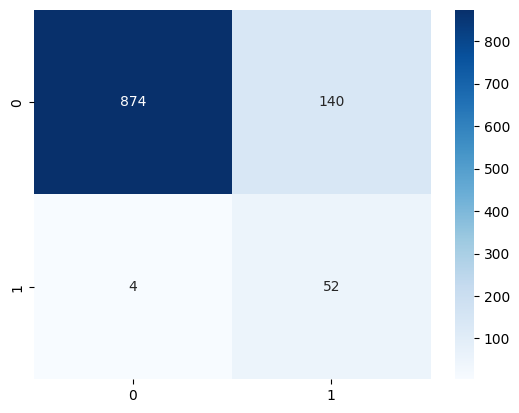

In [56]:
cm=confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [57]:
# smote
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)


In [58]:
lr=LogisticRegression(class_weight='balanced',max_iter=1000)
lr.fit(X_train_smote, Y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [59]:
y_pred_train=lr.predict(X_train_smote)

print(classification_report(Y_train_smote, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4059
           1       0.96      0.97      0.97      4059

    accuracy                           0.97      8118
   macro avg       0.97      0.97      0.97      8118
weighted avg       0.97      0.97      0.97      8118



In [60]:
y_pred=lr.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1014
           1       0.37      0.62      0.46        56

    accuracy                           0.92      1070
   macro avg       0.67      0.78      0.71      1070
weighted avg       0.95      0.92      0.93      1070



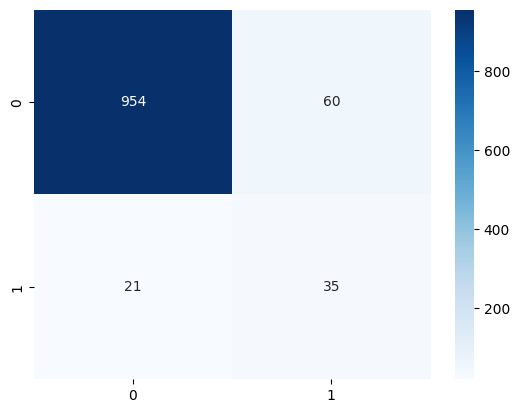

In [61]:
cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [62]:
#xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(scale_pos_weight=np.sum(Y_train_smote==0)/np.sum(Y_train_smote==1))
xgb.fit(X_train_smote, Y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [63]:

y_pred_train=xgb.predict(X_train_smote)

print(classification_report(Y_train_smote, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4059
           1       0.98      0.99      0.99      4059

    accuracy                           0.99      8118
   macro avg       0.99      0.99      0.99      8118
weighted avg       0.99      0.99      0.99      8118



In [64]:
y_pred=xgb.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1014
           1       0.47      0.59      0.52        56

    accuracy                           0.94      1070
   macro avg       0.72      0.78      0.75      1070
weighted avg       0.95      0.94      0.95      1070



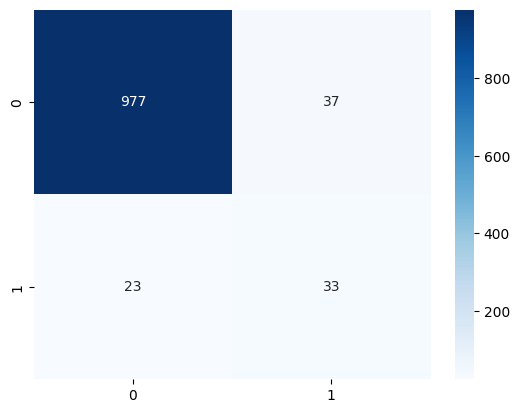

In [65]:
cm=confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');